### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
#import campnew data as dataframe
campnew=pd.read_csv('..\clean_data\campnew.csv')
campnew['date']=pd.to_datetime(campnew['date'], format='%d/%m/%Y')
print("date range is: ", campnew.date.min(), campnew.date.max())

date range is:  2018-09-17 00:00:00 2018-10-04 00:00:00


In [3]:
campnew=campnew.set_index('date')

### EDA

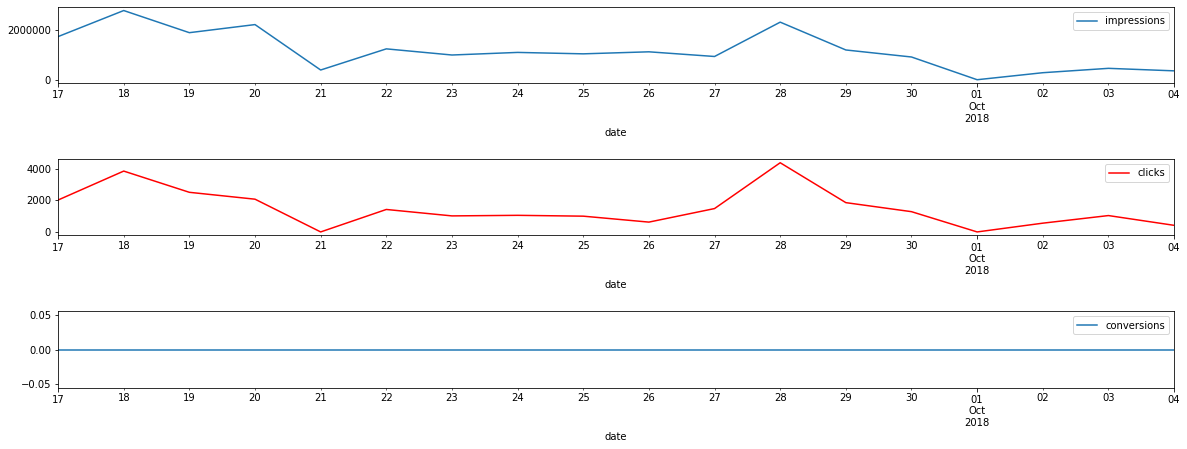

In [25]:
fig = plt.figure()
plt.subplots_adjust(hspace=1)

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

campnew.groupby(campnew.index)['impressions'].sum().plot(kind='line', ax=ax1, figsize=(20,14), legend = True)
campnew.groupby(campnew.index)['clicks'].sum().plot(kind='line', ax=ax2, figsize=(20,14), legend = True, color=['red'])
campnew.groupby(campnew.index)['conversions'].sum().plot(kind='line',ax=ax3, figsize=(20,7), legend = True)

#### <font color=red>Observation: </font>
#### As the value of conversions is always 0, there is no meaning to use a model to predict. Simply guess the future conversions is also 0.

### Decompose Impressions

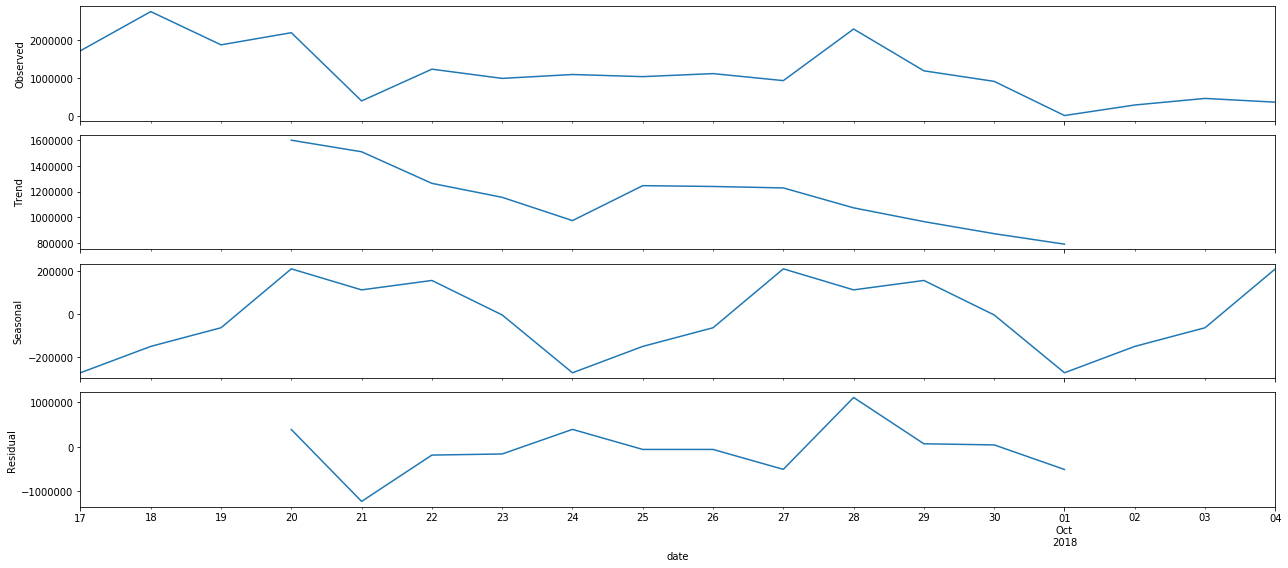

In [28]:
#decompose time series into three distinct components: trend, seasonality, and noise
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(campnew.groupby(campnew.index)['impressions'].sum(), model='additive')
fig = decomposition.plot()
plt.show()

#### <font color=red>Observation: </font>
####   From the decomposed charts, impressions' trend is relatively decreaing, and have obervious ***seasonality behavior***.

### ARIMA

#### From previous observation, we first differentiate the time series of impressions to make it more stationary, this helps determine the **d value** in ARIMA(p,d,q) model

In [5]:
#select impressions data series
series = campnew['impressions']
series.head()

date
2018-09-17     88.0
2018-09-17     48.0
2018-09-17    157.0
2018-09-17    124.0
2018-09-17    415.0
Name: impressions, dtype: float64

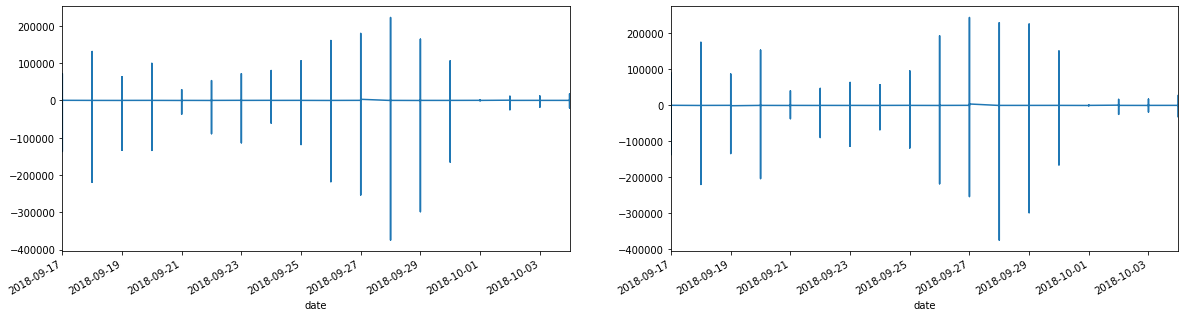

In [43]:
#try differentiating using 1 and 2
def parser(x):
	return dt.datetime.strptime(x, '%d/%m/%Y')
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
diff1 = series.diff(1)
diff1.plot(ax=ax1)
diff2 = series.diff(2)
diff2.plot(ax=ax2)

#### <font color=red>Observation: </font>
#### We will use 1 as value of d in model ARIMA(p,d,q) since 1 and 2 doesn't show much difference from the chart

### We need to determine p and q value, which will determine model selection
#### First, check the ACF and PACF with lags 100 and 20 

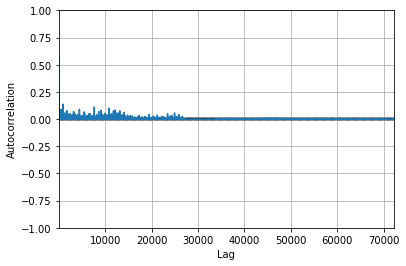

In [50]:
#autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

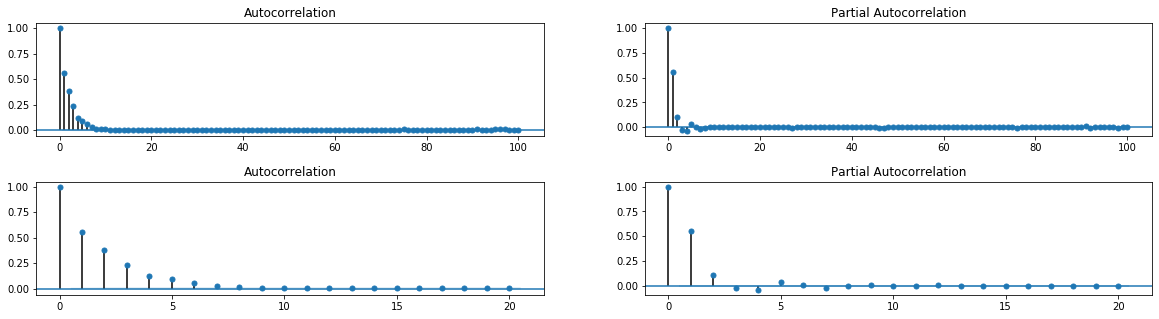

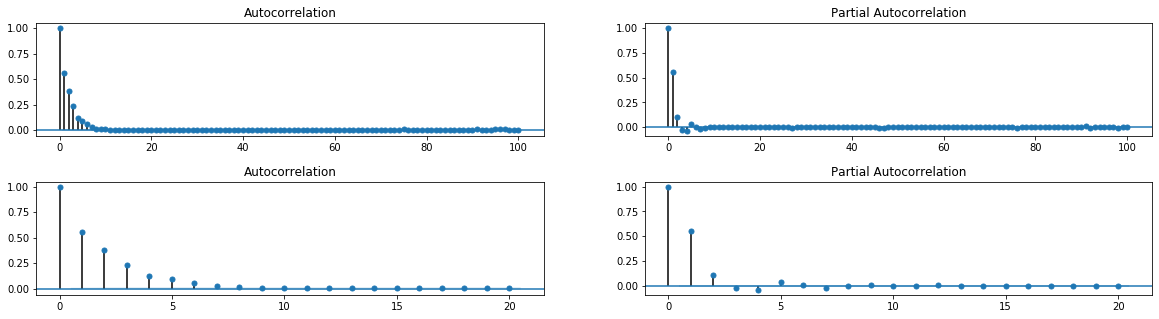

In [51]:
#acf & pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plot_acf(series,lags=100,ax=ax1)
plot_pacf(series, lags=100, ax=ax2)
plot_acf(series,lags=20,ax=ax3)
plot_pacf(series, lags=20, ax=ax4)

#### <font color=red>Observation: </font>
#### From ACF, the autocorrelations are significant for lag 6. After lag 6, the autocorrelation becomes 0. ---> MA(q)
#### From PACF, the partial autocorrelation is significant at lag 2. ---> AR(p)
#### Therefore, we will testing by using AR variable p=4, MA variable q=6.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.impressions   No. Observations:                72180
Model:                 ARIMA(4, 1, 6)   Log Likelihood             -690433.291
Method:                       css-mle   S.D. of innovations           3451.142
Date:                Sun, 15 Sep 2019   AIC                        1380890.582
Time:                        16:27:29   BIC                        1381000.825
Sample:                             1   HQIC                       1380924.535
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0059      0.016     -0.370      0.711      -0.037       0.025
ar.L1.D.impressions     1.0575      0.004    235.779      0.000       1.049       1.066
ar.L2.D.impressi

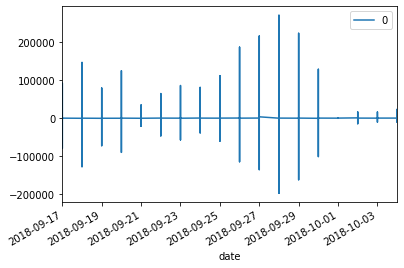

The density plot of the residual error values:


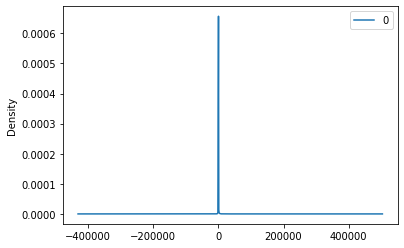

Below shows the distribution of the residual errors. The mean value shows there is a bias in the prediction:
                   0
count   72180.000000
mean       -1.606858
std      3451.363690
min   -197396.820349
25%      -186.303443
50%       -39.946134
75%        -0.874469
max    269949.352910


In [38]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(series, order=(4,1,6))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print("The residual errors show that there may still be some trend information not captured by the model:")
residuals.plot()
plt.show()
print("The density plot of the residual error values:")
residuals.plot(kind='kde')
plt.show()
print("Below shows the distribution of the residual errors. The mean value shows there is a bias in the prediction:")
print(residuals.describe())

In [52]:
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size],  X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=12.057169, expected=23.000000
predicted=17.848948, expected=61.000000
predicted=43.500820, expected=0.000000
predicted=12.117556, expected=10.000000
predicted=11.163831, expected=11.000000
predicted=12.413831, expected=2.000000
predicted=13.384864, expected=2.000000
predicted=1.975610, expected=0.000000
predicted=2.040163, expected=3.000000
predicted=3.708503, expected=13.000000
predicted=8.983279, expected=0.000000
predicted=2.768230, expected=1.000000
predicted=1.051162, expected=3.000000
predicted=2.541762, expected=32.000000
predicted=22.655341, expected=8.000000
predicted=10.880406, expected=38.000000
predicted=26.398837, expected=16.000000
predicted=17.628263, expected=24.000000
predicted=24.290806, expected=0.000000
predicted=6.173100, expected=184.000000
predicted=121.859269, expected=2.000000
predicted=37.109814, expected=1.000000
predicted=10.908087, expected=2.000000
predicted=1.596520, expected=11.000000
predicted=36.885846, expected=10.000000
predicted=8.621210, 

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.982389, expected=5.000000
predicted=3.903662, expected=0.000000
predicted=1.290285, expected=5.000000
predicted=3.768855, expected=0.000000
predicted=1.225530, expected=27.000000
predicted=17.833186, expected=0.000000
predicted=4.882030, expected=1.000000
predicted=2.315634, expected=0.000000
predicted=0.192621, expected=3.000000
predicted=6.250276, expected=1.000000
predicted=1.164317, expected=59.000000
predicted=37.294703, expected=48.000000
predicted=40.686508, expected=15.000000
predicted=20.474557, expected=1.000000
predicted=5.109375, expected=13.000000
predicted=18.318075, expected=55.000000
predicted=44.474995, expected=0.000000
predicted=12.786372, expected=0.000000
predicted=1.976727, expected=4.000000
predicted=4.619250, expected=0.000000
predicted=9.574231, expected=2.000000
predicted=1.377710, expected=1.000000
predicted=0.985173, expected=1.000000
predicted=1.511913, expected=12.000000
predicted=7.707890, expected=116.000000
predicted=74.987725, expected=1.00

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.636320, expected=4.000000
predicted=10.026864, expected=17.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.600853, expected=1.000000
predicted=4.150982, expected=0.000000
predicted=1.222704, expected=16.000000
predicted=10.678361, expected=25.000000
predicted=21.244942, expected=13.000000
predicted=13.326764, expected=16.000000
predicted=13.175377, expected=2.000000
predicted=7.157619, expected=0.000000
predicted=4.917435, expected=3.000000
predicted=4.038489, expected=0.000000
predicted=3.116054, expected=15.000000
predicted=9.787957, expected=26.000000
predicted=18.953142, expected=3.000000
predicted=7.549601, expected=1.000000
predicted=2.028839, expected=2.000000
predicted=3.955198, expected=1.000000
predicted=5.203311, expected=2.000000
predicted=1.976259, expected=50.000000
predicted=31.788509, expected=46.000000
predicted=38.163245, expected=0.000000
predicted=10.124440, expected=1.000000
predicted=2.486976, expected=1.000000
predicted=8.877559, expected=17.000000
predicted=18.235800, expected=75.000000
predicted=49.957093, expected=2.000000
predicted=15.530402, expected

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.271017, expected=0.000000
predicted=3.392703, expected=54.000000
predicted=34.123560, expected=45.000000
predicted=39.323500, expected=1.000000
predicted=10.859921, expected=1.000000
predicted=2.315165, expected=1.000000
predicted=9.553902, expected=31.000000
predicted=26.821228, expected=2.000000
predicted=7.046471, expected=9.000000
predicted=7.163430, expected=12.000000
predicted=9.364989, expected=26.000000
predicted=23.697203, expected=10.000000
predicted=11.667797, expected=0.000000
predicted=4.117194, expected=86.000000
predicted=55.997084, expected=74.000000
predicted=65.968012, expected=3.000000
predicted=19.695750, expected=4.000000
predicted=5.524431, expected=25.000000
predicted=30.323223, expected=31.000000
predicted=35.929945, expected=70.000000
predicted=50.640634, expected=6.000000
predicted=18.082798, expected=9.000000
predicted=13.052275, expected=8.000000
predicted=11.849650, expected=24.000000
predicted=28.005270, expected=30.000000
predicted=24.312372, 

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.475344, expected=4.000000
predicted=3.665577, expected=21.000000
predicted=14.649889, expected=1.000000
predicted=6.321547, expected=14.000000
predicted=9.617383, expected=1.000000
predicted=3.841805, expected=15.000000
predicted=13.390539, expected=0.000000
predicted=2.911015, expected=1.000000
predicted=3.369880, expected=1.000000
predicted=0.971617, expected=5.000000
predicted=5.748739, expected=1.000000
predicted=1.559011, expected=4.000000
predicted=3.002538, expected=8.000000
predicted=5.914347, expected=6.000000
predicted=6.128812, expected=51.000000
predicted=33.368306, expected=30.000000
predicted=28.806553, expected=36.000000
predicted=30.882503, expected=27.000000
predicted=25.356839, expected=31.000000
predicted=33.658379, expected=1.000000
predicted=11.966774, expected=1.000000
predicted=7.634266, expected=2.000000
predicted=5.824016, expected=1.000000
predicted=6.007142, expected=8.000000
predicted=5.402515, expected=25.000000
predicted=17.255964, expected=17.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1.596431, expected=0.000000
predicted=0.666091, expected=7.000000
predicted=6.012385, expected=14.000000
predicted=10.008900, expected=0.000000
predicted=2.919948, expected=7.000000
predicted=4.834736, expected=5.000000
predicted=5.520845, expected=2.000000
predicted=4.634672, expected=15.000000
predicted=9.897532, expected=22.000000
predicted=17.648287, expected=41.000000
predicted=30.888110, expected=4.000000
predicted=10.964983, expected=3.000000
predicted=6.372075, expected=61.000000
predicted=42.342730, expected=62.000000
predicted=56.460880, expected=39.000000
predicted=38.227192, expected=11.000000
predicted=16.481035, expected=20.000000
predicted=25.620088, expected=0.000000
predicted=13.979091, expected=2.000000
predicted=8.189699, expected=1.000000
predicted=2.765195, expected=4.000000
predicted=5.961939, expected=3.000000
predicted=2.628166, expected=0.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.993464, expected=0.000000
predicted=0.258717, expected=10.000000
predicted=6.889316, expected=12.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.784403, expected=13.000000
predicted=10.617258, expected=0.000000
predicted=2.748500, expected=6.000000
predicted=5.789803, expected=23.000000
predicted=17.389045, expected=0.000000
predicted=6.446404, expected=12.000000
predicted=8.254183, expected=2.000000
predicted=4.395018, expected=9.000000
predicted=10.078705, expected=1.000000
predicted=2.321541, expected=1.000000
predicted=3.031667, expected=33.000000
predicted=21.152687, expected=30.000000
predicted=26.187747, expected=11.000000
predicted=13.542190, expected=30.000000
predicted=21.894917, expected=6.000000
predicted=14.861925, expected=0.000000
predicted=6.905867, expected=6.000000
predicted=5.730359, expected=7.000000
predicted=10.287630, expected=36.000000
predicted=24.915398, expected=41.000000
predicted=32.353592, expected=7.000000
predicted=13.939743, expected=17.000000
predicted=14.380442, expected=38.000000
predicted=32.858971, expected=15.000000
predicted=23.403518, expected=2.000000
predicted=6.347012, exp

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.375932, expected=0.000000
predicted=1.318059, expected=1.000000
predicted=0.782894, expected=5.000000
predicted=3.461981, expected=13.000000
predicted=9.054905, expected=8.000000
predicted=7.510432, expected=0.000000
predicted=2.035427, expected=1.000000
predicted=1.697192, expected=1.000000
predicted=2.899557, expected=32.000000
predicted=21.488830, expected=29.000000
predicted=23.933310, expected=1.000000
predicted=7.081381, expected=5.000000
predicted=4.435463, expected=14.000000
predicted=14.847644, expected=29.000000
predicted=25.478702, expected=0.000000
predicted=5.865942, expected=7.000000
predicted=6.137804, expected=10.000000
predicted=9.779769, expected=23.000000
predicted=21.072451, expected=2.000000
predicted=5.738696, expected=0.000000
predicted=2.248612, expected=2.000000
predicted=2.934828, expected=5.000000
predicted=7.185695, expected=15.000000
predicted=10.659236, expected=5.000000
predicted=5.998562, expected=0.000000
predicted=1.719800, expected=2.00000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.655899, expected=3.000000
predicted=2.230636, expected=44.000000
predicted=28.351498, expected=30.000000
predicted=27.759297, expected=0.000000
predicted=6.873085, expected=1.000000
predicted=2.117685, expected=1.000000
predicted=7.902755, expected=6.000000
predicted=8.788393, expected=3.000000
predicted=2.989365, expected=7.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.271380, expected=0.000000
predicted=1.525805, expected=1.000000
predicted=1.819690, expected=0.000000
predicted=0.664502, expected=68.000000
predicted=43.636303, expected=72.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=57.272620, expected=1.000000
predicted=16.042852, expected=8.000000
predicted=7.585758, expected=6.000000
predicted=16.212560, expected=1.000000
predicted=13.561750, expected=41.000000
predicted=26.153529, expected=62.000000
predicted=47.466741, expected=1.000000
predicted=14.150472, expected=4.000000
predicted=4.903183, expected=6.000000
predicted=11.136870, expected=2.000000
predicted=12.444829, expected=19.000000
predicted=12.588666, expected=6.000000
predicted=7.894060, expected=21.000000
predicted=15.793510, expected=18.000000
predicted=15.569317, expected=2.000000
predicted=8.255212, expected=2.000000
predicted=3.178652, expected=3.000000
predicted=5.689353, expected=3.000000
predicted=5.378170, expected=6.000000
predicted=4.709400, expected=27.000000
predicted=18.371208, expected=1.000000
predicted=6.186328, expected=2.000000
predicted=2.802872, expected=6.000000
predicted=5.120783, expected=4.000000
predicted=7.993704, expected=6.000000
predicted=4.828083, expected=36

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.504662, expected=2.000000
predicted=2.727999, expected=7.000000
predicted=4.731899, expected=1.000000
predicted=2.114179, expected=0.000000
predicted=0.409338, expected=2.000000
predicted=1.605043, expected=1.000000
predicted=2.110610, expected=27.000000
predicted=17.271411, expected=11.000000
predicted=11.785083, expected=1.000000
predicted=3.822715, expected=1.000000
predicted=1.340965, expected=7.000000
predicted=8.936364, expected=0.000000
predicted=3.066983, expected=1.000000
predicted=1.013627, expected=0.000000
predicted=0.342538, expected=2.000000
predicted=2.406025, expected=0.000000
predicted=0.358989, expected=2.000000
predicted=1.473036, expected=6.000000
predicted=4.107765, expected=103.000000
predicted=65.813882, expected=64.000000
predicted=58.802465, expected=3.000000
predicted=17.163054, expected=1.000000
predicted=4.296697, expected=3.000000
predicted=18.768612, expected=16.000000
predicted=20.872404, expected=1.000000
predicted=4.097179, expected=2.000000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.741997, expected=5.000000
predicted=10.294224, expected=5.000000
predicted=4.385384, expected=7.000000
predicted=6.085941, expected=1.000000
predicted=3.020811, expected=5.000000
predicted=4.339510, expected=0.000000
predicted=1.742802, expected=0.000000
predicted=1.288990, expected=11.000000
predicted=7.032309, expected=3.000000
predicted=4.665011, expected=7.000000
predicted=5.274586, expected=0.000000
predicted=1.367682, expected=1.000000
predicted=2.624671, expected=2.000000
predicted=1.913943, expected=75.000000
predicted=48.370921, expected=135.000000
predicted=97.960528, expected=3.000000
predicted=28.916620, expected=1.000000
predicted=5.976062, expected=4.000000
predicted=14.925817, expected=1.000000
predicted=23.112973, expected=1.000000
predicted=1.417625, expected=2.000000
predicted=1.623212, expected=0.000000
predicted=1.035912, expected=7.000000
predicted=4.597129, expected=11.000000
predicted=8.296453, expected=833.000000
predicted=522.914733, expected=1161.0

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=52.968796, expected=2.000000
predicted=23.141374, expected=5.000000
predicted=5.909898, expected=29.000000
predicted=26.688183, expected=42.000000
predicted=42.591544, expected=1.000000
predicted=9.496751, expected=2.000000
predicted=3.632110, expected=14.000000
predicted=13.829678, expected=6.000000
predicted=13.104656, expected=3.000000
predicted=3.579259, expected=0.000000
predicted=1.066873, expected=13.000000
predicted=10.473982, expected=0.000000
predicted=3.315263, expected=2.000000
predicted=2.157449, expected=6.000000
predicted=4.114023, expected=6.000000
predicted=6.988744, expected=19.000000
predicted=13.149918, expected=0.000000
predicted=3.955684, expected=1.000000
predicted=2.216793, expected=6.000000
predicted=4.902527, expected=48.000000
predicted=34.159191, expected=3.000000
predicted=10.749169, expected=7.000000
predicted=6.657981, expected=5.000000
predicted=5.478087, expected=19.000000
predicted=20.730072, expected=1.000000
predicted=4.708997, expected=2.0

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=19.446871, expected=5.000000
predicted=6.387819, expected=3.000000
predicted=14.901967, expected=1.000000
predicted=16.300701, expected=6.000000
predicted=4.027530, expected=2.000000
predicted=3.170811, expected=1.000000
predicted=1.664399, expected=0.000000
predicted=0.407933, expected=2.000000
predicted=2.246233, expected=6.000000
predicted=4.429235, expected=5.000000
predicted=4.432205, expected=1.000000
predicted=1.724500, expected=2.000000
predicted=1.917165, expected=0.000000
predicted=1.360197, expected=0.000000
predicted=0.868222, expected=2.000000
predicted=1.408343, expected=2.000000
predicted=1.929866, expected=3.000000
predicted=2.298481, expected=5.000000
predicted=3.729849, expected=0.000000
predicted=1.322939, expected=2.000000
predicted=1.734631, expected=1.000000
predicted=1.468987, expected=0.000000
predicted=1.048491, expected=14.000000
predicted=8.776712, expected=3.000000
predicted=4.725134, expected=1.000000
predicted=1.786258, expected=0.000000
predicte

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.090422, expected=20.000000
predicted=14.624005, expected=69.000000
predicted=46.944714, expected=19.000000
predicted=25.003744, expected=30.000000
predicted=24.780338, expected=72.000000
predicted=54.285124, expected=3.000000
predicted=26.998404, expected=2.000000
predicted=7.236727, expected=1.000000
predicted=5.952575, expected=2.000000
predicted=13.085935, expected=11.000000
predicted=7.747309, expected=1.000000
predicted=2.999202, expected=4.000000
predicted=3.201061, expected=2.000000
predicted=2.330783, expected=6.000000
predicted=6.009994, expected=5.000000
predicted=4.434543, expected=12.000000
predicted=9.240226, expected=0.000000
predicted=2.657007, expected=0.000000
predicted=1.361018, expected=0.000000
predicted=0.808637, expected=1.000000
predicted=2.553463, expected=1.000000
predicted=0.802429, expected=2.000000
predicted=1.460076, expected=8.000000
predicted=5.389669, expected=4.000000
predicted=4.169812, expected=1.000000
predicted=1.770625, expected=0.00000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.658209, expected=4.000000
predicted=6.065975, expected=9.000000
predicted=6.870275, expected=18.000000
predicted=13.170888, expected=38.000000
predicted=29.865125, expected=2.000000
predicted=9.360075, expected=3.000000
predicted=4.943793, expected=5.000000
predicted=6.648240, expected=1.000000
predicted=7.743405, expected=9.000000
predicted=6.288491, expected=7.000000
predicted=6.516095, expected=0.000000
predicted=2.364806, expected=0.000000
predicted=0.393680, expected=3.000000
predicted=3.323933, expected=1.000000
predicted=2.291081, expected=1.000000
predicted=0.901324, expected=13.000000
predicted=8.333523, expected=38.000000
predicted=26.602812, expected=27.000000
predicted=24.325315, expected=43.000000
predicted=33.161794, expected=6.000000
predicted=14.524923, expected=7.000000
predicted=13.004453, expected=4.000000
predicted=8.330392, expected=7.000000
predicted=12.249744, expected=18.000000
predicted=13.609063, expected=54.000000
predicted=38.345505, expected=4.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=27.755089, expected=6.000000
predicted=12.105585, expected=5.000000
predicted=6.346331, expected=27.000000
predicted=25.227249, expected=4.000000
predicted=12.376074, expected=12.000000
predicted=10.075007, expected=34.000000
predicted=24.358782, expected=22.000000
predicted=24.632994, expected=1.000000
predicted=6.370923, expected=3.000000
predicted=4.727909, expected=7.000000
predicted=10.431446, expected=1.000000
predicted=5.528680, expected=16.000000
predicted=10.566305, expected=11.000000
predicted=10.281875, expected=11.000000
predicted=10.512447, expected=0.000000
predicted=2.518619, expected=1.000000
predicted=3.566162, expected=2.000000
predicted=3.204348, expected=0.000000
predicted=2.162477, expected=5.000000
predicted=3.186934, expected=1.000000
predicted=1.687967, expected=13.000000
predicted=8.785602, expected=77.000000
predicted=50.485398, expected=0.000000
predicted=15.154892, expected=5.000000
predicted=5.825673, expected=1.000000
predicted=3.662437, expected

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=35.010236, expected=22.000000
predicted=20.682463, expected=1.000000
predicted=8.842616, expected=2.000000
predicted=16.163812, expected=32.000000
predicted=22.004336, expected=16.000000
predicted=19.387029, expected=8.000000
predicted=9.104278, expected=1.000000
predicted=2.935634, expected=7.000000
predicted=9.975020, expected=9.000000
predicted=9.498423, expected=0.000000
predicted=3.143581, expected=1.000000
predicted=1.083164, expected=2.000000
predicted=2.559252, expected=2.000000
predicted=3.089899, expected=2.000000
predicted=1.674509, expected=5.000000
predicted=3.710159, expected=5.000000
predicted=4.413645, expected=15.000000
predicted=10.759468, expected=8.000000
predicted=8.196608, expected=15.000000
predicted=12.116099, expected=1.000000
predicted=4.411210, expected=2.000000
predicted=4.340791, expected=50.000000
predicted=32.922959, expected=77.000000
predicted=59.621678, expected=140.000000
predicted=103.188321, expected=1.000000
predicted=28.825444, expected=

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.958035, expected=61.000000
predicted=40.972668, expected=1.000000
predicted=13.684301, expected=2.000000
predicted=3.760588, expected=0.000000
predicted=0.909222, expected=2.000000
predicted=11.133215, expected=17.000000
predicted=11.140664, expected=0.000000
predicted=3.459010, expected=10.000000
predicted=6.805194, expected=6.000000
predicted=5.885142, expected=0.000000
predicted=4.148266, expected=4.000000
predicted=2.699144, expected=10.000000
predicted=8.580613, expected=5.000000
predicted=6.026528, expected=0.000000
predicted=1.232888, expected=5.000000
predicted=3.934854, expected=1.000000
predicted=3.138587, expected=3.000000
predicted=3.021599, expected=11.000000
predicted=7.446962, expected=9.000000
predicted=8.512785, expected=34.000000
predicted=23.389345, expected=63.000000
predicted=46.287033, expected=2.000000
predicted=15.534952, expected=2.000000
predicted=5.151866, expected=35.000000
predicted=27.798436, expected=1.000000
predicted=17.160193, expected=3.00

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.085576, expected=0.000000
predicted=0.522117, expected=10.000000
predicted=6.733219, expected=32.000000
predicted=23.566567, expected=67.000000
predicted=47.967870, expected=1.000000
predicted=13.797409, expected=1.000000
predicted=4.638003, expected=0.000000
predicted=5.400511, expected=4.000000
predicted=13.315648, expected=308.000000
predicted=193.289036, expected=740.000000
predicted=518.262773, expected=469.000000
predicted=436.945911, expected=1.000000
predicted=110.630528, expected=0.000000
predicted=65.634858, expected=28.000000
predicted=136.920587, expected=0.000000
predicted=80.565070, expected=6.000000
predicted=4.828687, expected=12.000000
predicted=8.594294, expected=20.000000
predicted=19.366353, expected=0.000000
predicted=4.012416, expected=12.000000
predicted=9.125083, expected=13.000000
predicted=12.231320, expected=2.000000
predicted=7.212373, expected=5.000000
predicted=3.917290, expected=3.000000
predicted=4.780431, expected=1.000000
predicted=3.422945

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.214405, expected=2.000000
predicted=4.621776, expected=2.000000
predicted=13.975707, expected=4.000000
predicted=3.086668, expected=1.000000
predicted=2.056069, expected=10.000000
predicted=6.879769, expected=1.000000
predicted=2.787271, expected=3.000000
predicted=3.025969, expected=1.000000
predicted=1.363867, expected=27.000000
predicted=18.754033, expected=40.000000
predicted=30.063069, expected=1.000000
predicted=9.228092, expected=44.000000
predicted=29.158748, expected=89.000000
predicted=67.954155, expected=1.000000
predicted=24.605543, expected=6.000000
predicted=7.044264, expected=0.000000
predicted=8.249116, expected=1.000000
predicted=15.148070, expected=17.000000
predicted=10.962153, expected=14.000000
predicted=12.815847, expected=7.000000
predicted=7.462245, expected=18.000000
predicted=13.139336, expected=37.000000
predicted=29.341254, expected=3.000000
predicted=11.412782, expected=21.000000
predicted=16.014363, expected=11.000000
predicted=13.683875, expec

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=47.644379, expected=34.000000
predicted=33.940859, expected=13.000000
predicted=16.460634, expected=0.000000
predicted=10.103534, expected=12.000000
predicted=17.761497, expected=0.000000
predicted=7.648164, expected=8.000000
predicted=7.482882, expected=0.000000
predicted=1.450609, expected=2.000000
predicted=3.441943, expected=1.000000
predicted=0.988023, expected=5.000000
predicted=4.655205, expected=3.000000
predicted=2.809430, expected=2.000000
predicted=2.276276, expected=0.000000
predicted=0.621452, expected=0.000000
predicted=0.869656, expected=28.000000
predicted=17.972568, expected=4.000000
predicted=7.881154, expected=13.000000
predicted=9.763978, expected=14.000000
predicted=11.241380, expected=31.000000
predicted=26.832518, expected=2.000000
predicted=7.964958, expected=3.000000
predicted=5.355091, expected=0.000000
predicted=2.877039, expected=6.000000
predicted=8.835921, expected=10.000000
predicted=7.652705, expected=0.000000
predicted=2.486090, expected=4.000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.101913, expected=0.000000
predicted=0.918997, expected=3.000000
predicted=3.291520, expected=38.000000
predicted=24.441188, expected=2.000000
predicted=8.860968, expected=7.000000
predicted=5.985445, expected=6.000000
predicted=5.581703, expected=9.000000
predicted=13.053759, expected=4.000000
predicted=4.647084, expected=0.000000
predicted=2.147387, expected=0.000000
predicted=1.100038, expected=1.000000
predicted=2.073046, expected=0.000000
predicted=0.821954, expected=1.000000
predicted=0.654805, expected=1.000000
predicted=0.803259, expected=1.000000
predicted=0.996627, expected=2.000000
predicted=1.460900, expected=29.000000
predicted=18.669374, expected=66.000000
predicted=46.698318, expected=6.000000
predicted=16.797862, expected=6.000000
predicted=7.343476, expected=37.000000
predicted=29.099793, expected=0.000000
predicted=17.514378, expected=1.000000
predicted=2.810328, expected=17.000000
predicted=11.784806, expected=30.000000
predicted=27.801592, expected=0.0000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3.328780, expected=5.000000
predicted=3.781097, expected=3.000000
predicted=4.232944, expected=7.000000
predicted=7.492168, expected=8.000000
predicted=6.362283, expected=6.000000
predicted=6.229337, expected=5.000000
predicted=4.956248, expected=5.000000
predicted=5.354050, expected=8.000000
predicted=7.355018, expected=5.000000
predicted=5.700879, expected=17.000000
predicted=12.592546, expected=4585.000000
predicted=2868.252948, expected=3952.000000
predicted=3299.725962, expected=3034.000000
predicted=2761.832209, expected=7246.000000
predicted=5210.746054, expected=7057.000000
predicted=6559.082493, expected=3.000000
predicted=2154.754986, expected=5.000000
predicted=728.992843, expected=7.000000
predicted=1175.827361, expected=9.000000
predicted=1143.023262, expected=5.000000
predicted=5.464645, expected=396.000000
predicted=249.393085, expected=682.000000
predicted=498.943937, expected=537.000000
predicted=473.286457, expected=564.000000
predicted=472.951883, expected=

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23.082777, expected=475.000000
predicted=301.207516, expected=621.000000
predicted=484.357166, expected=1.000000
predicted=143.472263, expected=2.000000
predicted=23.936057, expected=1.000000
predicted=77.992761, expected=9.000000
predicted=105.586413, expected=11.000000
predicted=8.683208, expected=0.000000
predicted=2.605194, expected=5.000000
predicted=3.662226, expected=7.000000
predicted=6.726234, expected=12.000000
predicted=10.686290, expected=10.000000
predicted=8.644905, expected=0.000000
predicted=3.015118, expected=4.000000
predicted=3.970875, expected=1294.000000
predicted=810.619696, expected=2006.000000
predicted=1487.314155, expected=1.000000
predicted=405.675281, expected=2.000000
predicted=71.400898, expected=8.000000
predicted=215.444772, expected=0.000000
predicted=323.633725, expected=2.000000
predicted=1.679665, expected=2.000000
predicted=1.936536, expected=0.000000
predicted=1.709865, expected=0.000000
predicted=0.067292, expected=2.000000
predicted=1.5

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=20.741832, expected=13.000000
predicted=79.142935, expected=41.000000
predicted=112.826165, expected=2.000000
predicted=9.233068, expected=9.000000
predicted=7.861501, expected=1.000000
predicted=4.444428, expected=1.000000
predicted=7.692473, expected=1.000000
predicted=1.167125, expected=2.000000
predicted=2.906425, expected=11.000000
predicted=7.421382, expected=2.000000
predicted=3.456345, expected=3.000000
predicted=2.765913, expected=3.000000
predicted=2.812183, expected=40.000000
predicted=27.383376, expected=5.000000
predicted=10.748229, expected=11.000000
predicted=9.605211, expected=3.000000
predicted=4.548005, expected=1.000000
predicted=7.963165, expected=2.000000
predicted=2.343235, expected=0.000000
predicted=2.161155, expected=1.000000
predicted=1.172351, expected=2.000000
predicted=1.589095, expected=0.000000
predicted=0.712529, expected=1.000000
predicted=0.690618, expected=6.000000
predicted=4.086655, expected=1.000000
predicted=2.057195, expected=5.000000
p

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.838394, expected=6.000000
predicted=5.370157, expected=0.000000
predicted=1.642996, expected=1.000000
predicted=1.796459, expected=0.000000
predicted=1.308406, expected=2.000000
predicted=2.243400, expected=3.000000
predicted=2.231772, expected=1.000000
predicted=1.390286, expected=6.000000
predicted=4.027516, expected=1.000000
predicted=2.060693, expected=16.000000
predicted=10.853246, expected=0.000000
predicted=3.080029, expected=169.000000
predicted=107.020181, expected=805.000000
predicted=533.217284, expected=6.000000
predicted=156.999665, expected=5.000000
predicted=31.656589, expected=1.000000
predicted=29.792770, expected=35.000000
predicted=151.467398, expected=5.000000
predicted=10.425015, expected=1.000000
predicted=3.511441, expected=2568.000000
predicted=1603.896056, expected=3.000000
predicted=469.980319, expected=3.000000
predicted=90.184618, expected=3.000000
predicted=5.641283, expected=2.000000
predicted=414.243100, expected=1.000000
predicted=1.568688, e

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.189494, expected=3.000000
predicted=2.930877, expected=6.000000
predicted=5.028459, expected=2.000000
predicted=2.592448, expected=322.000000
predicted=202.059652, expected=4.000000
predicted=61.047219, expected=6.000000
predicted=16.345685, expected=1.000000
predicted=2.543119, expected=0.000000
predicted=52.085124, expected=9.000000
predicted=6.299074, expected=2.000000
predicted=3.831480, expected=5.000000
predicted=3.944629, expected=2.000000
predicted=2.225030, expected=20.000000
predicted=14.459848, expected=0.000000
predicted=3.994529, expected=1888.000000
predicted=1180.093224, expected=2.000000
predicted=341.645888, expected=1.000000
predicted=68.201934, expected=0.000000
predicted=2.497041, expected=49.000000
predicted=333.755287, expected=1.000000
predicted=9.769515, expected=19.000000
predicted=13.860313, expected=0.000000
predicted=3.511914, expected=0.000000
predicted=8.510070, expected=2.000000
predicted=1.429153, expected=2.000000
predicted=4.656741, expecte

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=37.915582, expected=51.000000
predicted=43.327388, expected=65.000000
predicted=53.191816, expected=105.000000
predicted=82.900836, expected=132.000000
predicted=112.085064, expected=103.000000
predicted=99.890930, expected=0.000000
predicted=33.577140, expected=139.000000
predicted=107.300323, expected=341.000000
predicted=259.235339, expected=906.000000
predicted=648.281965, expected=1405.000000
predicted=1051.993333, expected=1154.000000
predicted=1026.813442, expected=2.000000
predicted=312.450500, expected=2.000000
predicted=187.969470, expected=1.000000
predicted=228.050689, expected=2.000000
predicted=186.781653, expected=1.000000
predicted=1.339181, expected=0.000000
predicted=0.567603, expected=5.000000
predicted=3.316188, expected=3.000000
predicted=3.092545, expected=8.000000
predicted=5.862411, expected=9.000000
predicted=7.164148, expected=0.000000
predicted=2.694912, expected=0.000000
predicted=0.794433, expected=1.000000
predicted=1.917301, expected=9.000000
pr

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.407263, expected=1.000000
predicted=0.835697, expected=0.000000
predicted=0.212612, expected=2.000000
predicted=1.441847, expected=2.000000
predicted=1.767852, expected=0.000000
predicted=0.585826, expected=7.000000
predicted=4.438119, expected=15.000000
predicted=10.945767, expected=344.000000
predicted=218.024645, expected=77.000000
predicted=110.498397, expected=1.000000
predicted=27.296053, expected=2.000000
predicted=6.875242, expected=1.000000
predicted=56.340512, expected=4.000000
predicted=15.106213, expected=9.000000
predicted=6.533271, expected=0.000000
predicted=2.075288, expected=2.000000
predicted=1.717066, expected=0.000000
predicted=1.010797, expected=2.000000
predicted=2.758940, expected=1.000000
predicted=0.984218, expected=3.000000
predicted=2.439387, expected=3.000000
predicted=2.446781, expected=3.000000
predicted=2.834510, expected=1.000000
predicted=1.427793, expected=1.000000
predicted=1.388950, expected=1.000000
predicted=1.321079, expected=1.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=20.188450, expected=38.000000
predicted=29.259992, expected=88.000000
predicted=62.753824, expected=2.000000
predicted=18.420109, expected=3.000000
predicted=9.922607, expected=3.000000
predicted=8.688206, expected=2.000000
predicted=16.019352, expected=1.000000
predicted=1.408588, expected=1.000000
predicted=1.355086, expected=1.000000
predicted=1.319880, expected=1.000000
predicted=1.158090, expected=1.000000
predicted=0.997532, expected=20.000000
predicted=12.856976, expected=0.000000
predicted=3.794979, expected=2.000000
predicted=2.087045, expected=1.000000
predicted=1.167148, expected=3.000000
predicted=5.329175, expected=2.000000
predicted=1.822567, expected=2.000000
predicted=2.030289, expected=1.000000
predicted=1.214063, expected=1.000000
predicted=1.353852, expected=1.000000
predicted=1.159323, expected=4.000000
predicted=3.030633, expected=1.000000
predicted=1.537790, expected=1.000000
predicted=1.099441, expected=1.000000
predicted=1.001244, expected=0.000000
pre

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1.181336, expected=1.000000
predicted=1.513173, expected=0.000000
predicted=0.374597, expected=11.000000
predicted=7.219793, expected=9.000000
predicted=7.757888, expected=9.000000
predicted=7.770131, expected=15.000000
predicted=11.300311, expected=0.000000
predicted=4.781794, expected=1.000000
predicted=2.587351, expected=1.000000
predicted=2.265329, expected=9.000000
predicted=8.237510, expected=10.000000
predicted=7.895301, expected=27.000000
predicted=19.118742, expected=1.000000
predicted=5.995446, expected=29.000000
predicted=20.653311, expected=7.000000
predicted=11.262241, expected=12.000000
predicted=14.069601, expected=18.000000
predicted=13.827995, expected=1.000000
predicted=8.935674, expected=1.000000
predicted=2.551948, expected=0.000000
predicted=2.160494, expected=0.000000
predicted=2.922705, expected=8.000000
predicted=5.152735, expected=1.000000
predicted=2.222955, expected=0.000000
predicted=0.449350, expected=1.000000
predicted=0.665551, expected=0.000000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.001230, expected=7.000000
predicted=4.848555, expected=31.000000
predicted=20.608009, expected=147.000000
predicted=97.573979, expected=307.000000
predicted=219.156778, expected=119.000000
predicted=135.713761, expected=4.000000
predicted=39.512738, expected=3.000000
predicted=30.614380, expected=1.000000
predicted=50.734964, expected=8.000000
predicted=24.384061, expected=22.000000
predicted=15.850220, expected=22.000000
predicted=18.445968, expected=28.000000
predicted=22.354400, expected=1.000000
predicted=7.722674, expected=2.000000
predicted=5.936806, expected=1.000000
predicted=4.582566, expected=1.000000
predicted=5.366529, expected=2.000000
predicted=1.622987, expected=4.000000
predicted=3.210761, expected=1.000000
predicted=1.571732, expected=1.000000
predicted=1.100738, expected=1.000000
predicted=1.161813, expected=5.000000
predicted=3.976002, expected=1.000000
predicted=1.717816, expected=13.000000
predicted=8.623824, expected=70.000000
predicted=46.232698, expe

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.338556, expected=1.000000
predicted=1.753989, expected=4.000000
predicted=3.328838, expected=1.000000
predicted=1.702918, expected=1.000000
predicted=1.742023, expected=1.000000
predicted=1.001235, expected=2.000000
predicted=2.103403, expected=5.000000
predicted=3.674328, expected=1.000000
predicted=1.751542, expected=1.000000
predicted=1.135152, expected=1.000000
predicted=1.163006, expected=3.000000
predicted=2.888145, expected=15.000000
predicted=10.096276, expected=39.000000
predicted=27.304852, expected=48.000000
predicted=37.653477, expected=25.000000
predicted=26.070592, expected=0.000000
predicted=8.589044, expected=1.000000
predicted=7.794003, expected=13.000000
predicted=16.028853, expected=30.000000
predicted=25.110835, expected=87.000000
predicted=60.146258, expected=202.000000
predicted=142.942122, expected=129.000000
predicted=121.962845, expected=2.000000
predicted=36.271257, expected=6.000000
predicted=22.714896, expected=22.000000
predicted=47.465928, exp

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.840804, expected=1.000000
predicted=1.479166, expected=1.000000
predicted=0.997582, expected=0.000000
predicted=0.373550, expected=1.000000
predicted=0.817504, expected=0.000000
predicted=0.339413, expected=1.000000
predicted=0.816252, expected=1.000000
predicted=0.802916, expected=1.000000
predicted=0.996332, expected=1.000000
predicted=0.837055, expected=1.000000
predicted=0.997584, expected=1.000000
predicted=0.997583, expected=5.000000
predicted=3.493714, expected=4.000000
predicted=3.589997, expected=22.000000
predicted=14.779059, expected=1.000000
predicted=4.886675, expected=0.000000
predicted=1.736335, expected=0.000000
predicted=0.701288, expected=2.000000
predicted=4.778477, expected=17.000000
predicted=11.126787, expected=7.000000
predicted=7.495421, expected=13.000000
predicted=9.953393, expected=51.000000
predicted=34.745485, expected=28.000000
predicted=29.836037, expected=0.000000
predicted=7.920814, expected=11.000000
predicted=9.968384, expected=70.000000
p

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=2.242287, expected=2.000000
predicted=2.626894, expected=11.000000
predicted=10.341600, expected=0.000000
predicted=2.209818, expected=4.000000
predicted=3.192710, expected=0.000000
predicted=1.052743, expected=9.000000
predicted=7.516163, expected=53.000000
predicted=34.696760, expected=59.000000
predicted=47.309038, expected=121.000000
predicted=87.950254, expected=1.000000
predicted=25.937106, expected=1.000000
predicted=13.513768, expected=1.000000
predicted=10.458495, expected=12.000000
predicted=27.125314, expected=13.000000
predicted=10.466866, expected=8.000000
predicted=7.902293, expected=2.000000
predicted=3.305600, expected=2.000000
predicted=3.821487, expected=1.000000
predicted=3.146934, expected=0.000000
predicted=1.532663, expected=3.000000
predicted=2.227345, expected=6.000000
predicted=4.604298, expected=1.000000
predicted=1.965046, expected=1.000000
predicted=1.010240, expected=0.000000
predicted=0.700890, expected=1.000000
predicted=1.620156, expected=0.000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=146.671854, expected=4.000000
predicted=117.517023, expected=1.000000
predicted=76.131967, expected=3.000000
predicted=98.665131, expected=5.000000
predicted=3.857646, expected=2.000000
predicted=2.891853, expected=2.000000
predicted=1.940796, expected=2.000000
predicted=2.161937, expected=9.000000
predicted=6.847402, expected=5.000000
predicted=5.130319, expected=7.000000
predicted=5.897003, expected=3.000000
predicted=3.633286, expected=31.000000
predicted=21.572566, expected=4.000000
predicted=8.990145, expected=3.000000
predicted=4.775779, expected=9.000000
predicted=6.811007, expected=16.000000
predicted=16.686536, expected=1.000000
predicted=4.456101, expected=4.000000
predicted=3.712862, expected=1.000000
predicted=2.840887, expected=0.000000
predicted=2.883950, expected=3.000000
predicted=2.069348, expected=9.000000
predicted=6.797429, expected=8.000000
predicted=6.873501, expected=28.000000
predicted=19.221944, expected=45.000000
predicted=33.886986, expected=14.0000

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.969492, expected=12.000000
predicted=10.790713, expected=9.000000
predicted=8.324814, expected=20.000000
predicted=15.010115, expected=1.000000
predicted=7.114055, expected=3.000000
predicted=4.670147, expected=3.000000
predicted=3.913857, expected=2.000000
predicted=5.100145, expected=1.000000
predicted=1.248498, expected=2.000000
predicted=1.979355, expected=17.000000
predicted=11.484401, expected=33.000000
predicted=24.042405, expected=39.000000
predicted=31.020703, expected=1.000000
predicted=9.113862, expected=2.000000
predicted=5.527454, expected=1.000000
predicted=6.362191, expected=0.000000
predicted=6.507820, expected=1.000000
predicted=0.818797, expected=312.000000
predicted=195.195096, expected=1154.000000
predicted=776.501856, expected=817.000000
predicted=728.294907, expected=1406.000000
predicted=1064.451465, expected=1.000000
predicted=333.242419, expected=3.000000
predicted=236.320887, expected=4.000000
predicted=135.980224, expected=1.000000
predicted=227.

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1.406195, expected=1.000000
predicted=0.981806, expected=0.000000
predicted=0.245964, expected=1.000000
predicted=0.658279, expected=4.000000
predicted=2.996114, expected=6.000000
predicted=4.656774, expected=4.000000
predicted=3.712014, expected=4.000000
predicted=3.584405, expected=0.000000
predicted=1.504118, expected=1.000000
predicted=1.726361, expected=87.000000
predicted=55.115177, expected=47.000000
predicted=45.670431, expected=72.000000
predicted=56.362480, expected=78.000000
predicted=63.511607, expected=26.000000
predicted=46.751432, expected=62.000000
predicted=53.667041, expected=51.000000
predicted=55.531480, expected=81.000000
predicted=74.398248, expected=0.000000
predicted=20.576702, expected=2.000000
predicted=14.027262, expected=5764.000000
predicted=3605.538397, expected=11347.000000
predicted=8132.244163, expected=22430.000000
predicted=16239.895379, expected=24979.000000
predicted=20026.373041, expected=0.000000
predicted=6198.228881, expected=0.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.694917, expected=1.000000
predicted=1.446645, expected=1.000000
predicted=1.157038, expected=0.000000
predicted=0.212715, expected=1.000000
predicted=0.817822, expected=1.000000
predicted=0.963599, expected=1.000000
predicted=0.996429, expected=3.000000
predicted=2.085689, expected=1.000000
predicted=1.357300, expected=0.000000
predicted=0.441423, expected=1.000000
predicted=0.820260, expected=1.000000
predicted=1.284817, expected=0.000000
predicted=0.372106, expected=6.000000
predicted=3.778835, expected=0.000000
predicted=1.238403, expected=0.000000
predicted=0.362526, expected=1.000000
predicted=0.629258, expected=4.000000
predicted=3.638399, expected=7.000000
predicted=5.121244, expected=1.000000
predicted=2.018142, expected=4.000000
predicted=3.078573, expected=15.000000
predicted=10.766804, expected=26.000000
predicted=20.189116, expected=28.000000
predicted=22.830399, expected=0.000000
predicted=6.578734, expected=1.000000
predicted=4.016153, expected=1.000000
predic

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=142.849026, expected=117.000000
predicted=113.562743, expected=159.000000
predicted=132.905498, expected=14.000000
predicted=55.526102, expected=11.000000
predicted=45.122564, expected=22.000000
predicted=35.174718, expected=37.000000
predicted=52.983823, expected=41.000000
predicted=35.260271, expected=62.000000
predicted=49.130966, expected=93.000000
predicted=74.183595, expected=5.000000
predicted=27.952075, expected=14.000000
predicted=19.456562, expected=20.000000
predicted=25.245148, expected=57.000000
predicted=54.599592, expected=42.000000
predicted=37.973631, expected=31.000000
predicted=31.116539, expected=46.000000
predicted=39.001439, expected=1.000000
predicted=19.158747, expected=1.000000
predicted=9.147816, expected=0.000000
predicted=5.247388, expected=0.000000
predicted=7.421284, expected=1.000000
predicted=0.783807, expected=63.000000
predicted=39.668062, expected=24.000000


c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=26.350750, expected=83.000000
predicted=58.271940, expected=98.000000
predicted=77.165654, expected=103.000000
predicted=94.899626, expected=279.000000
predicted=199.991030, expected=173.000000
predicted=175.151511, expected=0.000000
predicted=56.467622, expected=3.000000
predicted=24.631550, expected=5.000000
predicted=48.684405, expected=9.000000
predicted=34.404661, expected=9.000000
predicted=7.409155, expected=12.000000
predicted=9.902129, expected=38.000000
predicted=26.999464, expected=11.000000
predicted=15.566660, expected=72.000000
predicted=49.675937, expected=86.000000
predicted=68.989545, expected=46.000000
predicted=52.751258, expected=107.000000
predicted=79.848638, expected=119.000000
predicted=106.773356, expected=0.000000
predicted=38.913403, expected=1.000000
predicted=12.182440, expected=2.000000
predicted=18.758885, expected=6.000000
predicted=23.250747, expected=1.000000
predicted=1.770747, expected=2.000000
predicted=1.792975, expected=2.000000
predicte

c:\users\chloe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.132149, expected=3.000000
predicted=7.532413, expected=2.000000
predicted=4.550525, expected=4.000000
predicted=2.957778, expected=7.000000
predicted=5.319641, expected=1.000000
predicted=2.501677, expected=2.000000
predicted=1.990009, expected=5.000000
predicted=4.164021, expected=2.000000
predicted=3.339411, expected=6.000000
predicted=4.436100, expected=2.000000
predicted=2.721190, expected=1.000000
predicted=1.991105, expected=5.000000
predicted=3.695565, expected=2.000000
predicted=3.146075, expected=1.000000
predicted=1.474070, expected=2.000000
predicted=1.660865, expected=3.000000
predicted=3.069916, expected=2.000000
predicted=2.176440, expected=8.000000
predicted=5.616760, expected=7.000000
predicted=6.200028, expected=7.000000
predicted=6.383183, expected=7.000000
predicted=6.196008, expected=11.000000
predicted=9.655611, expected=17.000000
predicted=13.960461, expected=37.000000
predicted=27.661573, expected=40.000000
predicted=33.341902, expected=66.000000
pred

NameError: name 'pyplot' is not defined

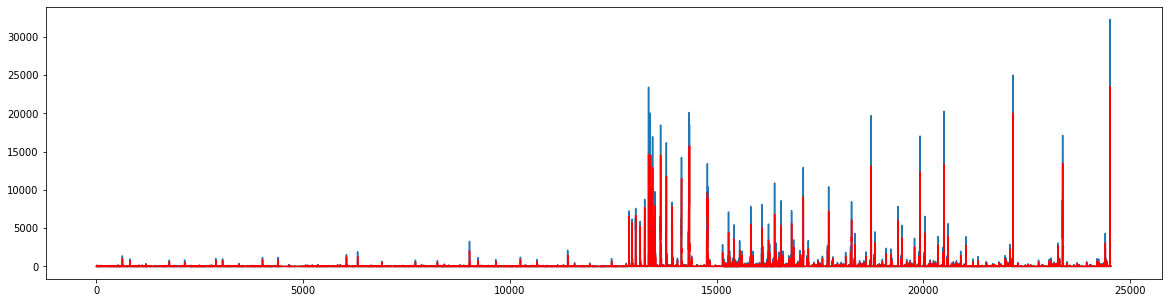

In [58]:
#plot
fig = plt.figure(figsize=(20,5))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()